# Modelling BG

## Model Shapping

In [1]:
import numpy as np
import os
import pandas as pd
from pipelines import pipeline

train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)
additional_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_5h.csv')
additional_data = pd.read_csv(additional_data_file, low_memory=False)

# merge train and additional data
train_data = pd.concat([train_data, additional_data], axis=0)

# read validation data
validation_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_3h.csv')
validation_data = pd.read_csv(validation_data_file, low_memory=False)

# do not train with patients that are not have to be predicted
unique_patients = validation_data['p_num'].unique()
train_data = train_data[train_data['p_num'].isin(unique_patients)]

train_data_processed = pipeline.fit_transform(train_data)
validation_data_processed = pipeline.transform(validation_data)

## Feature importance Lasso

In [2]:
# Load and preprocess the train data 
from src.features.tuners import LassoHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

train_and_validation_data = pd.concat([train_data_processed, validation_data_processed])

X = train_and_validation_data.drop(columns=['bg+1:00'])
y = train_and_validation_data['bg+1:00']

tuner = LassoHyperparameterTuner()
tuner.fit(X, y)
model = tuner.get_best_model()

model.fit(X=X, y=y)
y_pred = model.predict(X=X)

root_mean_squared_error(y_true=y, y_pred=y_pred)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_)
}).sort_values(by='Importance', ascending=False)

feature_importance

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.947e+05, tolerance: 1.980e+02
  model = cd_fast.enet_coordinate_descent(
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.911e+05, tolerance: 1.985e+02
  model = cd_fast.enet_coordinate_descent(
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinat

,Feature,Importance
36,bg-0:00,5.571850
35,bg-0:05,2.500654
34,bg-0:10,0.813160
219,p_num_p21,0.803894
212,p_num_p10,0.695568
...,...,...
180,cals-0:20,0.000000
182,cals-0:10,0.000000
40,insulin-2:45,0.000000
30,bg-0:30,0.000000


In [ ]:
from tqdm.notebook import tqdm

root_mean_squared_errors_train = {}
root_mean_squared_errors_val = {}

X_train = train_data_processed.drop(columns=['bg+1:00'])
y_train = train_data_processed['bg+1:00']

X_val = validation_data_processed.drop(columns=['bg+1:00'])
y_val = validation_data_processed['bg+1:00']

for i in tqdm(range(1, len(feature_importance))):
    selected_features = feature_importance['Feature'].values[:i]
    X_train_loop = X_train[selected_features]
    X_val_loop = X_val[selected_features]
    model = tuner.get_best_model()

    model.fit(X=X_train_loop, y=y_train)
    y_train_predict = model.predict(X=X_train_loop)
    y_pred = model.predict(X=X_val_loop)

    root_mean_squared_errors_train[i] = root_mean_squared_error(y_train, y_train_predict)
    root_mean_squared_errors_val[i] = root_mean_squared_error(y_val, y_pred)


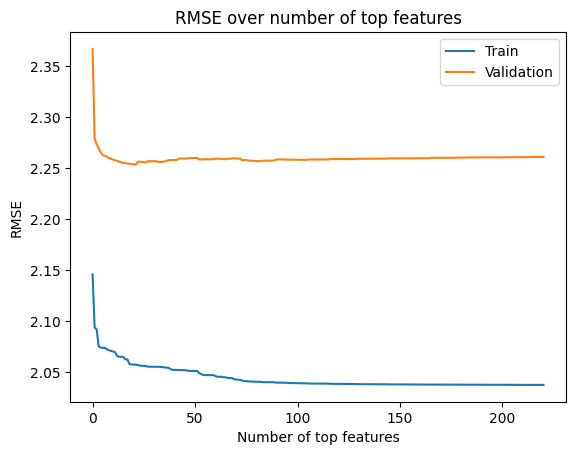

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(root_mean_squared_errors_train.values(), label='Train')
plt.plot(root_mean_squared_errors_val.values(), label='Validation')
plt.legend()
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [5]:
# Find the key with the minimum value
min_key = min(root_mean_squared_errors_val, key=root_mean_squared_errors_val.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", root_mean_squared_errors_val[min_key])

Index with the minimum value: 22
Minimum value: 2.253353836730453
